## 1. Import thư viện

In [160]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import pandas as pd

## 2. Đọc và hiển thị ảnh gốc

Image shape: (1080, 1920)


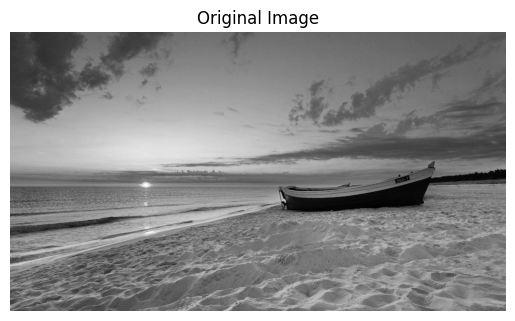

In [161]:
# Đọc ảnh xám
img = cv2.imread("test.png", cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis("off")

print("Image shape:", img.shape)

## 3. Chuẩn bị dữ liệu bí mật

In [162]:
secret_bits = np.random.randint(0, 2, size=2000).tolist()

print("Secret bits:", len(secret_bits))

Secret bits: 2000


## 4. Hàm nhúng tin

In [163]:
def de_embed(image, secret_bits, T=2):
    h, w = image.shape
    stego = image.copy().astype(np.int32)

    location_map = []
    bit_idx = 0

    for i in range(h):
        for j in range(0, w - 1, 2):
            if bit_idx >= len(secret_bits):
                location_map.append(0)
                continue

            x = stego[i, j]
            y = stego[i, j + 1]

            l = (x + y) // 2
            d = x - y

            if abs(d) <= T:
                b = secret_bits[bit_idx]
                d_new = 2 * d + b

                x_new = l + (d_new + 1) // 2
                y_new = l - d_new // 2

                if 0 <= x_new <= 255 and 0 <= y_new <= 255:
                    stego[i, j] = x_new
                    stego[i, j + 1] = y_new
                    location_map.append(1)
                    bit_idx += 1
                else:
                    location_map.append(0)
            else:
                location_map.append(0)

    return stego.astype(np.uint8), location_map, bit_idx

## 5. Thực hiện nhúng tin

Embedded bits: 2000


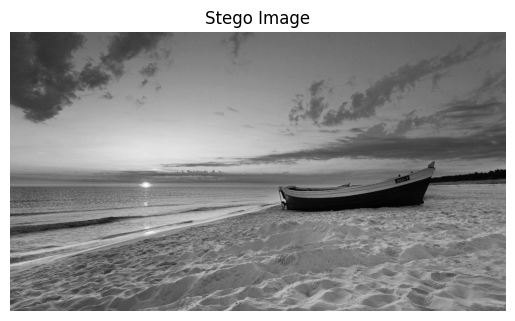

In [164]:
stego_img, location_map, used_bits = de_embed(img, secret_bits, T=2)

plt.imshow(stego_img, cmap='gray')
plt.title("Stego Image")
plt.axis("off")

print("Embedded bits:", used_bits)

## 6. Hàm trích xuất 

In [165]:
def de_extract(stego, location_map, bit_count):
    h, w = stego.shape
    recovered = stego.copy().astype(np.int32)

    extracted_bits = []
    lm_idx = 0

    for i in range(h):
        for j in range(0, w - 1, 2):

            if location_map[lm_idx] == 1:
                x = recovered[i, j]
                y = recovered[i, j + 1]

                d_new = x - y
                b = d_new & 1
                d = d_new // 2

                l = (x + y) // 2

                x_orig = l + (d + 1) // 2
                y_orig = l - d // 2

                recovered[i, j] = x_orig
                recovered[i, j + 1] = y_orig

                extracted_bits.append(b)

            lm_idx += 1

    return recovered.astype(np.uint8), extracted_bits

## 7. Hàm phục hồi

In [166]:
recovered_img, extracted_bits = de_extract(
    stego_img, location_map, used_bits
)

print("Data extraction correct:",
      extracted_bits[:used_bits] == secret_bits[:used_bits])

print("Perfect recovery:",
      np.array_equal(img, recovered_img))

Data extraction correct: True
Perfect recovery: True


## 8. Hàm tính chỉ số

In [167]:
def compute_psnr(original, stego):
    mse = np.mean((original.astype(float) - stego.astype(float)) ** 2)
    if mse == 0:
        return float("inf")
    return 10 * np.log10((255 ** 2) / mse)

def compute_ssim(original, stego):
    value, _ = ssim(original, stego, full=True)
    return value

def compute_payload_bpp(used_bits, image_shape):
    total_pixels = image_shape[0] * image_shape[1]
    bpp = used_bits / total_pixels
    return used_bits, bpp

## 9. Tính toàn bộ thông số

In [168]:
payload, bpp = compute_payload_bpp(used_bits, img.shape)
psnr_value = compute_psnr(img, stego_img)
ssim_value = compute_ssim(img, stego_img)
reversible = np.array_equal(img, recovered_img)

results = pd.DataFrame({
    "Metric": [
        "Payload (bits)",
        "Embedding Capacity (bpp)",
        "PSNR (dB)",
        "SSIM",
        "Perfect Reversibility"
    ],
    "Value": [
        payload,
        bpp,
        psnr_value,
        ssim_value,
        reversible
    ]
})

results

,Metric,Value
0,Payload (bits),2000
1,Embedding Capacity (bpp),0.000965
2,PSNR (dB),78.652236
3,SSIM,0.999997
4,Perfect Reversibility,True
